In [227]:
import pandas as pd 
import numpy as np
import pymysql
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [325]:
conn = pymysql.connect(host=,  
                       port=,  
                       user=,  
                       passwd=,  
                       db=,  
                       charset='utf8')  

In [4]:
sql_con = "select * from consumer"
sql_con_prod = "select * from consumer_product"
sql_con_ser = "select * from consumer_servicerequest"
sql_sold = "select * from sold_plan"

In [326]:
df_con = pd.read_sql(sql_con,conn)
df_con_prod = pd.read_sql(sql_con_prod,conn)
df_con_serv = pd.read_sql(sql_con_ser,conn)
df_sold = pd.read_sql(sql_sold,conn)


# EDA

# Converting Object datatype into datetime64


- The datatype of two columns 'DateOfPurchase' & 'WarrantyTill' in 'consumer_product' table is 'object'.
- So, for further analysis we need to convert the datatype of the above two columns to 'datetime64'.

In [327]:
df_con_prod['DateOfPurchase'] = pd.to_datetime(df_con_prod['DateOfPurchase'])
df_con_prod['WarrantyTill'] = pd.to_datetime(df_con_prod['WarrantyTill'])


# All Tables - Description

- The description of all the tables show that the dataset has NO NULL value.
- In 'consumer_Servicerequest' table, the column 'SoldPlanID' has value '0'. This means that particular consumer has not opted   for any plan.

In [249]:
df_con.describe()
df_con_prod.describe()
df_con_serv.describe()
df_sold.describe()

,SoldPlanID,PlanID,PlanAmount,FulfillerID,ConsumerProductID,ConsumerID,Status
count,2.321500e+04,23215.000000,23215.000000,23215.0,2.321500e+04,23215.000000,23215.000000
mean,9.993116e+05,9.986000,1348.950463,1.0,1.002056e+07,501018.936463,0.232393
std,5.750154e+05,5.474269,228.041644,0.0,5.777678e+06,287227.354238,2.165259
min,1.830000e+02,1.000000,999.000000,1.0,2.305000e+03,56.000000,-3.000000
25%,5.035295e+05,5.000000,1299.000000,1.0,5.013360e+06,255174.500000,-3.000000
50%,9.996500e+05,10.000000,1299.000000,1.0,1.004843e+07,498297.000000,0.000000
75%,1.498953e+06,15.000000,1499.000000,1.0,1.502322e+07,749913.500000,1.000000
max,1.999999e+06,19.000000,1599.000000,1.0,1.999927e+07,999966.000000,3.000000


# EDA on consumer_servicerequest and sold_plan table

Observation 1 :

From the initial EDA of 'consumer_servicerequest' table it is observed that the value of 'SoldPlanID' column for many rows is zero. 

e.g 
- Total record in consumer_servicerequest = 27546
- Total zeroes in SoldPlanId column = 18241 = ~66% of total service requests.

We can conclude from the above observation, ~33% consumers are using their paid plans to request a service and rest of the ~66% consumers are using their device warranty to request a service.



In [195]:
df_con_serv[df_con_serv['SoldPlanID'] == 0]['SoldPlanID'].count()

18241

Observation 2 :

It is observed from 'consumer_servicerequest' table, there are 5 unique types of services ('ServiceTypeID') available to the consumers. And according to 'sold_plan' table values, paid consumers are using only 3 types of services ('ServiceTypeID').

The observation is explained below :

In [211]:
#Total ServiceTypeID = 5 (Types = 1, 2, 10, 11, 12) 

print('Total Unique ServiceTypeID : ', df_con_serv['ServiceTypeID'].unique())
print('\nTotal number of Service request raised on each ServiceType:',df_con_serv.groupby(['ServiceTypeID'])['ServiceTypeID'].count())

Total Unique ServiceTypeID :  [ 1  2 12 11 10]

Total number of Service request raised on each ServiceType: ServiceTypeID
1     9264
2     8977
10    3075
11    3143
12    3087
Name: ServiceTypeID, dtype: int64


In [1]:
#Query - inner join of 'consumer_servicerequest' and 'sold_plan' table
sql_service = "select cs.ConsumerID, sp.SoldPlanID, cs.ServiceTypeID, sp.PlanID, sp.PlanAmount, cs.Source from consumer_servicerequest cs inner join sold_plan sp on cs.SoldPlanID = sp.SoldPlanID AND cs.ConsumerProductID = sp.ConsumerProductID"

In [200]:
#Dataframe containing Inner join dataset
df_service  = pd.read_sql(sql_service, conn)

In [217]:
#Types of paid services consumers are using - only 3 Types = 10, 11, 12.
print('Total number of Service request raised on each ServiceType by Paid Consumers:\n',df_service.groupby(['ServiceTypeID'])['SoldPlanID'].count())

#Total sum of SoldPlanID using Service = 9305
print('\nTotal paid consumers raising Servicerequest:',df_service.groupby(['ServiceTypeID'])['SoldPlanID'].count().sum())

Total number of Service request raised on each ServiceType by Paid Consumers:
 ServiceTypeID
10    3075
11    3143
12    3087
Name: SoldPlanID, dtype: int64

Total paid consumers raising Servicerequest: 9305


Observation 3 :

It can be concluded that only 40% paid plan holders are requesting a service. 
    - Total consumers bought the plan = 23215
    - Total consumers raised the service request from paid plans = 9305 = ~40% consumers used their paid plan.
    - ~60% 'paid plan holders' still don't have any issue with their devices.
    

In [239]:
df_sold['SoldPlanID'].count()

23215

In [240]:
df_service['SoldPlanID'].count()

9305

Observation 4 :

From the 'sold_plan' table we get to know that the consumers opt a paid service through 5 sources.

- And almost all the sources are effective for the sale of plans because all the sources fetched almost equal number of consumers. 
    

In [222]:
df_sold.groupby(['Source'])['ConsumerID'].count()

Source
Amazon     4611
App        4672
Offline    4551
Store      4722
Web        4659
Name: ConsumerID, dtype: int64

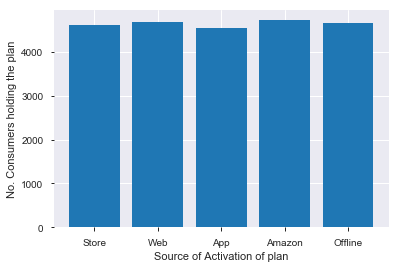

In [238]:
plt.bar( df_sold['Source'].unique(), df_sold.groupby(['Source'])['ConsumerID'].count())
plt.xlabel('Source of Activation of plan')
plt.ylabel('No. Consumers holding the plan')
plt.show()

# Total Revenue Generated

Observation 5 : 

Through analysis, it is observed that PlanId 14 is generating the highest revenue for the company and comparatively PlanId 5 is generating the lowest revenue.

So we can use this observation to make certain policy changes in the low revenue generating plans.

In [250]:
sql_revenue = 'select PlanID, PlanAmount, Count(ConsumerID) from sold_plan group by PlanID, PlanAmount'

In [252]:
df_revenue = pd.read_sql(sql_revenue,conn)

In [253]:
#Total Revenue Generated groupby with planID and PlanAmount:
df_revenue['TotalRevenue'] = df_revenue['PlanAmount'] * df_revenue['Count(ConsumerID)']


In [254]:
a = df_revenue['PlanID'].unique()
b = df_revenue.groupby(['PlanID'])['TotalRevenue'].sum().values

In [255]:
#Total revenue fetched by each Plan from first to last Date: 
#ag is a Dataframe having PlanId and TotalRevenue columns
ag = np.array([a,b])
ag = pd.DataFrame({'PlanID':ag[0,:], 'TotalRevenue':ag[1,:]})


#Highest and Lowest Revenue generated by PLans:
#HIghest
print("Highest revenue generated by :",ag[ag['TotalRevenue'] == ag['TotalRevenue'].max()][['PlanID','TotalRevenue']].to_string(index=False))

#lowest
print("Lowest Revenue generated by :",ag[ag['TotalRevenue'] == ag['TotalRevenue'].min()][['PlanID','TotalRevenue']].to_string(index=False))


Highest revenue generated by :  PlanID  TotalRevenue
     14       1732729
Lowest Revenue generated by :  PlanID  TotalRevenue
      5       1563929


# The brand (BrandID) with the highest number of plans bought by customers

Observation 6 :

The consumers with a particular BrandId (i.e 16) are opting highest number of paid plans for a service. So as a service provider, we must focus on the popularity of the service opted for that brand.

In [296]:
# query
sql_brand  = "select sp.ConsumerID, cp.BrandID, sp.PlanID from  consumer_product as cp inner join sold_plan as sp on cp.ConsumerID = sp.ConsumerID AND cp.ConsumerProductID = sp.ConsumerProductID;"

In [297]:
df_brand = pd.read_sql(sql_brand,conn)

In [299]:
#Groupby
df_brand = df_brand.groupby(['BrandID'], as_index=False).count()

In [300]:
#Max() of PlanID total numbers under each Brand:
print("The brand (BrandID) with the highest number of plans bought by customers : ",df_brand[df_brand['PlanID'] == df_brand['PlanID'].max()]['BrandID'].to_string(index=False))

The brand (BrandID) with the highest number of plans bought by customers :   16


Observation 7 : 

Apart from all the above observations, there is one more observation which was not analyzed due to incorrect values in the table. The observation is explained below : 
     
     - From the 'consumer_servicerequest' table, the columns 'Lat', 'Lng' and 'Zipcode' can be used to analyze the consumer's service requests coming from a particular area and through which we can tap a good customer base. Thus the service provider can design certain service plans for future customer choices.